In [1]:
import rebound as rb
from matplotlib import pyplot as plt
import celmech as cm
import numpy as np
import sympy as sp

In [2]:
sim=rb.Simulation()
sim.add(m=1)
sim.add(m=1e-4,P=1)
sim.add(m=1e-4,P=1.5)
pvars = cm.Poincare.from_Simulation(sim)
pham = cm.PoincareHamiltonian(pvars)

In [3]:
pham.add_MMR_terms(3,1)

In [4]:
A = np.eye(pham.N_dof,dtype = int)
A[0,:4] = [-2,3,1,0]
A[1,:4] = [-2,3,0,1]
A[2,:4] = [1,-1,0,0]
A[3,:4] = [-2,3,0,0]
angvars=sp.symbols("theta1,theta2,psi,l,phi1,phi2",real=True)
actions=sp.symbols("p1,p2,Psi,L,Phi1,Phi2",positive=True)
_,_,Psi,L,_,_=actions
ct1 = cm.CanonicalTransformation.from_poincare_angles_matrix(pvars,A,new_qp_pairs=list(zip(angvars,actions)))

'ham1' will be the Hamiltonian in the resonant variables you're used to

In [5]:
ham1=ct1.old_to_new_hamiltonian(pham,do_reduction=True)
ham1.H

                                                                    ____      
  √2⋅C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅╲╱ p₁ ⋅cos(θ
- ────────────────────────────────────────────────────────────────────────────
                              _______________                                 
                            ╲╱ \Lambda_{1,0} ⋅a_{2,0}                         

                                                                       ____   
₁)   √2⋅C_{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅╲╱ p₂ ⋅co
── - ─────────────────────────────────────────────────────────────────────────
                                 _______________                              
                               ╲╱ \Lambda_{2,0} ⋅a_{2,0}                      

                  2   2   3                    2   2   3        
s(θ₂)            G ⋅M₁ ⋅μ₁                    G ⋅M₂ ⋅μ₂         
───── - ─────────────────────────── - ──────────────────────────
             

'ham2' transforms from polar $(\theta_i,p_i)$ variables to cartesian $(y_i,x_i)$ variables. These are usually more convenient for numerical integration and root-finding

In [6]:
ct2 = cm.CanonicalTransformation.polar_to_cartesian(ham1.full_qp_vars,indices=[0,1])

ham2=ct2.old_to_new_hamiltonian(ham1)
ham2.H

                                                                              
  C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅x₁   C_{(3,-2,0
- ─────────────────────────────────────────────────────────────── - ──────────
                       _______________                                        
                     ╲╱ \Lambda_{1,0} ⋅a_{2,0}                                

                                                                              
,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅x₂                         
───────────────────────────────────────────────────── - ──────────────────────
           _______________                                 2                 2
         ╲╱ \Lambda_{2,0} ⋅a_{2,0}                      8⋅L  - 8⋅L⋅Ψ + 8⋅L⋅x₁ 

                                                                            2 
                                                                           G ⋅
──────────────────────────────────────────────────

A composite transformation representing all the transformations so far

In [7]:
ct_all = cm.CanonicalTransformation.composite([ct1,ct2])

In [8]:
oldvars = ct_all.old_qp_vars
_,eta1,_,_,eta2,_,L1,kappa1,_,L2,kappa2,_= oldvars
newvars = ct_all.new_qp_vars
y1,y2,_,_,_,_,x1,x2,Psi,L,_,_ = newvars

Conserved quantities after transformation:

In [9]:
L,ct_all.new_to_old(L)

⎛               2     2     2     2⎞
⎜             η₁    η₂    κ₁    κ₂ ⎟
⎜L, Λ₁ + Λ₂ - ─── - ─── - ─── - ───⎟
⎝              2     2     2     2 ⎠

In [10]:
Psi,ct_all.new_to_old(Psi)

(Ψ, 3⋅Λ₁ + 2⋅Λ₂)

## dissipation
The effect of dissipation, written in terms of the original variables

In [11]:
tau_a1,tau_a2,tau_e1,tau_e2 = sp.symbols("tau_a1,tau_a2,tau_e1,tau_e2")
disflow = sp.Matrix(np.zeros(pham.N_dim))
for hk,tau in zip([(eta1,kappa1),(eta2,kappa2)],(tau_e1,tau_e2)):
    h,k = hk
    disflow[oldvars.index(h)] = -h/tau
    disflow[oldvars.index(k)] = -k/tau
disflow[oldvars.index(L1)] = -L1/tau_a1/sp.S(2)
disflow[oldvars.index(L2)] = -L2/tau_a2/sp.S(2)
disflow

⎡  0  ⎤
⎢     ⎥
⎢-η₁  ⎥
⎢──── ⎥
⎢τₑ₁  ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢-η₂  ⎥
⎢──── ⎥
⎢τₑ₂  ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢ -Λ₁ ⎥
⎢─────⎥
⎢2⋅τₐ₁⎥
⎢     ⎥
⎢-κ₁  ⎥
⎢──── ⎥
⎢τₑ₁  ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢ -Λ₂ ⎥
⎢─────⎥
⎢2⋅τₐ₂⎥
⎢     ⎥
⎢-κ₂  ⎥
⎢──── ⎥
⎢τₑ₂  ⎥
⎢     ⎥
⎣  0  ⎦

Define $(D, L_2)$ new variables s.t.
$$
\begin{pmatrix}
L\\
\Psi
\end{pmatrix}
= 
\begin{pmatrix}
-1 & 1+\rho\\
0 & j\rho+(j-1)
\end{pmatrix}
\cdot
\begin{pmatrix}
D\\
L_2
\end{pmatrix}
$$
where $\rho = \left(\frac{\Lambda_1}{\Lambda_2}\right)_\mathrm{res} \approx \frac{m_1}{m_2}\left(\frac{j-1}{j}\right)^{1/3}$.

In terms of old variables,
$$
L = \Lambda_{1} + \Lambda_{2} - \frac{\eta_{1}^{2}}{2} - \frac{\eta_{2}^{2}}{2} - \frac{\kappa_{1}^{2}}{2} - \frac{\kappa_{2}^{2}}{2} = (1 + \rho)L_2 - D\\
\Psi = j \Lambda_{1} + (j-1) \Lambda_{2} = (j\rho+(j-1))L_2~.
$$
In other words, $L_2$ represents the value of $\Lambda_2$ when the planets' instantaneous period ratio is at the exact resonant value and $D$ is the value of $(p_1+p_2)$ when $\Lambda_2 = L_2$.

The planets' period ratio can be expressed in terms of 
$$
\Delta = \frac{j-1}{j}\frac{P_2}{P_1} - 1 \approx 3\left(\frac{\Lambda_2 - L_2}{L_2} - \frac{\Lambda_1 - \rho L_2}{\rho L_2}\right) = 3\frac{\delta\Lambda_2}{L_2}\left(1+\frac{j-1}{j\rho}\right)
$$
where $\delta\Lambda_2 = \Lambda_2 - L_2$

Therefore, we can write 
$$
D = p_1+p_2+(1+\rho)L_2-\Lambda_1 - \Lambda_2
$$
Or
$$
\begin{eqnarray}
D &=& p_1+p_2 - \frac{1}{j}\delta\Lambda_2\\
  &=& p_1+p_2 + \frac{1}{3}\left(\frac{\rho L_2}{j\rho+j-1}\right)\Delta
\end{eqnarray}
$$

The dissipative evolution of $D$ is therefore
$$
\begin{eqnarray}
\dot{D}\big|_\mathrm{dis} &=&-\frac{p_1}{\tau_{e1}}-\frac{p_2}{\tau_{e2}}- \frac{1}{3}\left(\frac{\rho L_2}{j\rho+j-1}\right)\dot{\Delta}\big|_\mathrm{dis}\\
&=&
-\frac{p_1}{\tau_{e1}}-\frac{p_2}{\tau_{e2}}-\frac{1}{2}\left(\frac{\rho L_2}{j\rho+j-1}\right)\frac{1}{\tau_\alpha}
\end{eqnarray}
$$
where I've used $\dot{\Delta}\big|_\mathrm{dis}=\frac{2}{3}\frac{1}{\tau_\alpha}$ with $\tau_\alpha^{-1} = \tau_{a,1}^{-1}- \tau_{a,2}^{-1}$

Convert from $L,\Psi$ to $D,L_2$

In [13]:
D,L2res,rho = sp.symbols("D,L2,rho")
rho_val = (pham.particles[1].m/pham.particles[2].m) * (2/3)**(1/3) 
mtrx = sp.Matrix([[-1,1+rho],[0,3*rho + 2]]) 
D_exprn,L2res_exprn = mtrx.inv() * sp.Matrix([L,Psi])
Dval,L2val = [float(s.subs(ham2.full_qp).subs({rho:rho_val})) for s in (D_exprn,L2res_exprn)]
newvars = [y1,y2,x1,x2,D_exprn]
subsrule = dict(zip([L,Psi],mtrx * sp.Matrix([D,L2res])))


 Initial value of $D$

In [25]:
from sympy.simplify.fu import TR10,TR10i,TR11
mtrx_func = lambda i,j: sp.simplify(TR10i(TR10(sp.diff(ct_all.new_to_old(newvars[i]),oldvars[j]))))
jac_old = sp.Matrix(len(newvars),len(oldvars),mtrx_func)
newdisflow = sp.simplify(ct_all.old_to_new(jac_old * disflow))

newdisflow = newdisflow.subs(subsrule)

p1 = (x1*x1 + y1*y1)/sp.S(2)
p2 = (x2*x2 + y2*y2)/sp.S(2)
factor = rho * L2res / (3*rho+2)
tau_alpha = 1/(1/tau_a1 - 1/tau_a2)
Ddot_dis = -1*factor *(1/sp.S(2))* 1/tau_alpha - p1/tau_e1 - p2/tau_e2
newdisflow_approx = sp.Matrix([(newdisflow[i] if i<4 else Ddot_dis) for i in range(5)])

Ddot_dis

                         2     2     2     2
       ⎛   1     1 ⎞   x₂    y₂    x₁    y₁ 
  L₂⋅ρ⋅⎜- ─── + ───⎟   ─── + ───   ─── + ───
       ⎝  τₐ₂   τₐ₁⎠    2     2     2     2 
- ────────────────── - ───────── - ─────────
     2⋅(3⋅ρ + 2)          τₑ₂         τₑ₁   

In [15]:
newdisflow_approx

⎡                    -y₁                     ⎤
⎢                    ────                    ⎥
⎢                    τₑ₁                     ⎥
⎢                                            ⎥
⎢                    -y₂                     ⎥
⎢                    ────                    ⎥
⎢                    τₑ₂                     ⎥
⎢                                            ⎥
⎢                    -x₁                     ⎥
⎢                    ────                    ⎥
⎢                    τₑ₁                     ⎥
⎢                                            ⎥
⎢                    -x₂                     ⎥
⎢                    ────                    ⎥
⎢                    τₑ₂                     ⎥
⎢                                            ⎥
⎢                         2     2     2     2⎥
⎢       ⎛   1     1 ⎞   x₂    y₂    x₁    y₁ ⎥
⎢  L₂⋅ρ⋅⎜- ─── + ───⎟   ─── + ───   ─── + ───⎥
⎢       ⎝  τₐ₂   τₐ₁⎠    2     2     2     2 ⎥
⎢- ────────────────── - ───────── - ─────────⎥
⎣     2⋅(3⋅ρ 

We'll need to substitute the following numerical values into our equations of motion in a few places:

In [16]:
newpars = {L2res:L2val,rho:rho_val}
newpars

{L₂: 6.203374794995148e-05, ρ: 0.8735804647362989}

conservative flow expressed in term of dynamical variables (need to augment with $\dot{D}=0$)

In [17]:
newflow = ham2.flow.subs(subsrule).subs(ham2.H_params).subs(newpars)

dissipative flow in terms of new dynamical varaibles:

In [19]:
fullflow = sp.Matrix(list(newflow) + [0]) + newdisflow_approx.subs(newpars) 
taus = [tau_a1,tau_a2,tau_e1,tau_e2]

dyvars = [y1, y2, x1, x2, D]

flow_fn=sp.lambdify(dyvars+taus,fullflow)

jac_fn=sp.lambdify(
    dyvars+taus,
    sp.Matrix(5,5,lambda i,j : sp.diff(fullflow[i],dyvars[j]) )
)

tauvals = [-1e5,+1e5,1e3,1e3]

In [21]:
from scipy.integrate import solve_ivp

times = np.linspace(0,6e3,200)
f=lambda t,x: flow_fn(*x,*tauvals).reshape(-1)
Df = lambda t,x: jac_fn(*x,*tauvals)
soln=solve_ivp(f,(times[0],times[-1]),[0,0,0,0,float(Dval)],method='Radau',t_eval=times,jac=Df)

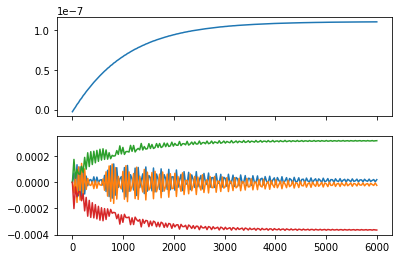

In [22]:
fig,ax= plt.subplots(2,1,sharex=True)
ax[0].plot(times,soln.y[-1])
ax[1].plot(soln.t,soln.y[0])
ax[1].plot(soln.t,soln.y[1])
ax[1].plot(soln.t,soln.y[2])
ax[1].plot(soln.t,soln.y[3])

In [23]:
import warnings
#warnings.filterwarnings("ignore")
from scipy.linalg import solve as lin_solve
def newton_solve(fun,Dfun,guess,max_iter=100,rtol=1e-6,atol=1e-12):
    y = guess.copy()
    for itr in range(max_iter):
        f = fun(y)
        Df = Dfun(y)
        dy = -1 * lin_solve(Df,f)
        y+=dy
        if np.alltrue( np.abs(dy) < rtol * np.abs(y) + atol ):
            break
    else:
        warnings.warn("did not converge")
    return y

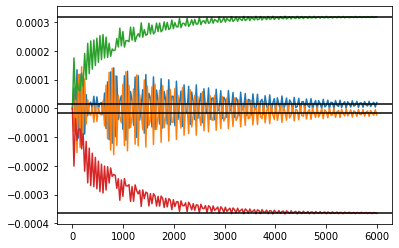

In [24]:
f=lambda x: flow_fn(*x,*tauvals).reshape(-1)
Df = lambda x: jac_fn(*x,*tauvals)
root=newton_solve(f,Df,soln.y.T[-1])

plt.plot(soln.t,soln.y[0])
plt.plot(soln.t,soln.y[1])
plt.plot(soln.t,soln.y[2])
plt.plot(soln.t,soln.y[3])
for r in root[:4]:
    plt.axhline(r,color='k')